In [3]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random, jit, grad
import numpy as np
from tqdm import tqdm
import time
from scipy.linalg import orth
import matplotlib.pyplot as plt

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

/local/ipykernel_2951912/1991717721.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


gpu


In [6]:
# Compute the supremum norm ‖E‖ := sup‖θ‖=1 |E(θ, θ, θ)|
def sup_norm(tensor, num_initializations=1000000, seed=42):
    """
    Maximize the supremum norm over multiple random initializations.

    Parameters:
        tensor (jnp.ndarray): Input tensor of shape (k, k, k).
        num_initializations (int): Number of random initializations to try.
        seed (int): Random seed for reproducibility.

    Returns:
        float: Maximum approximated supremum norm.
    """
    # Function to compute the supremum norm for a single random initialization
    def inter_sup_norm(tensor, key, k):
        theta = random.normal(key, (k,))
        theta /= jnp.linalg.norm(theta)  # Normalize to lie on the unit sphere
        return jnp.abs(jnp.tensordot(tensor, jnp.einsum('i,j,k->ijk', theta, theta, theta), axes=([0, 1, 2], [0, 1, 2])))

    # Generate random keys for the number of initializations
    key = random.PRNGKey(seed)
    keys = random.split(key, num_initializations)  # Generate multiple subkeys
    k = tensor.shape[0]

    # Use vmap to vectorize the sup_norm function over the keys
    sup_norms = jax.vmap(lambda subkey: inter_sup_norm(tensor, subkey, k))(keys)
    
    # Return the maximum value from the supremum norms
    return jnp.max(sup_norms)


In [7]:
def generate_symmetric_tensor(k, sup_norm_bound=0.01, seed=42):
    """
    Generate a random symmetric k x k x k tensor with sup norm < sup_norm_bound.
    
    Parameters:
        k (int): Dimension of the tensor.
        sup_norm_bound (float): Upper bound for the supremum norm.
        seed (int): Random seed for reproducibility.
    
    Returns:
        jnp.ndarray: A symmetric k x k x k tensor.
    """
    key = random.PRNGKey(seed)

    # Generate a random tensor
    random_tensor = random.normal(key, (k, k, k))

    # Symmetrize the tensor
    sym_tensor = (random_tensor 
                  + jnp.transpose(random_tensor, (0, 2, 1)) 
                  + jnp.transpose(random_tensor, (1, 2, 0)) 
                  + jnp.transpose(random_tensor, (1, 0, 2)) 
                  + jnp.transpose(random_tensor, (2, 0, 1)) 
                  + jnp.transpose(random_tensor, (2, 1, 0))) / 6

    # Compute the supremum norm ‖E‖ := sup‖θ‖=1 |E(θ, θ, θ)|
    
    current_sup_norm = sup_norm(sym_tensor)

    # Scale the tensor to ensure sup norm is within bounds
    scaling_factor = sup_norm_bound / current_sup_norm if current_sup_norm > 0 else 0
    scaled_tensor = sym_tensor * scaling_factor

    return scaled_tensor


In [8]:
def generate_orthogonal_tensor(k, inf_norm=10, sup_norm=40, seed=42):
    """
    Generate a random orthogonally decomposable k*k*k tensor with given supremum norm.
    
    Parameters:
        k (int): Size of the tensor.
        sup_norm (float): Desired supremum norm of the tensor.
        seed (int): Random seed for reproducibility.
        
    Returns:
        tensor (jnp.ndarray): The generated orthogonally decomposable tensor.
        eigenvalues (jnp.ndarray): The eigenvalues used in the tensor decomposition.
        eigenvectors (jnp.ndarray): The orthonormal vectors used in the decomposition.
    """
    key = random.PRNGKey(seed)
    
    # Generate random orthonormal vectors
    random_matrix = random.normal(key, (k, k))
    eigenvectors = orth(random_matrix)  # Orthonormal vectors, shape (k, k)
    
    # Normalize eigenvectors to have unit norm (if necessary)
    eigenvectors = eigenvectors / jnp.linalg.norm(eigenvectors, axis=0, keepdims=True)
        
    # Generate random eigenvalues and scale to match the supremum norm
    random_key, subkey = random.split(key)
    eigenvalues = random.uniform(subkey, (k,), minval=inf_norm, maxval=sup_norm)
    
    # Construct the tensor
    tensor = jnp.zeros((k, k, k))
    for i in range(k):
        vi = eigenvectors[:, i]
        rank_one_tensor = jnp.einsum('i,j,k->ijk', vi, vi, vi)
        tensor += eigenvalues[i] * rank_one_tensor
    
    return tensor, eigenvalues, eigenvectors


In [9]:
def tensor_power_iteration(tensor, L, N, seed=42):
    """
    Power iteration for symmetric tensors using JAX, parallelized over L initializations.

    Parameters:
        tensor (jnp.ndarray): Symmetric tensor of shape (k, k, k).
        L (int): Number of random initializations.
        N (int): Number of iterations for power iteration.

    Returns:
        best_theta (jnp.ndarray): Estimated eigenvector.
        lambda_val (float): Estimated eigenvalue.
        deflated_tensor (jnp.ndarray): Deflated tensor.
    """
    key = random.PRNGKey(seed)
    k = tensor.shape[0]
    best_theta = None
    best_value = -jnp.inf
    
    def power_iteration(theta, tensor, N):
        """Perform power iteration for a single initialization."""
        def cond_fn(state):
            theta, prev_theta, count = state
            norm_diff = jnp.linalg.norm(theta - prev_theta)
            return jax.lax.select(
                jax.lax.ge(norm_diff, 1e-6),  # Replacing >= with jax.lax.ge
                jax.lax.lt(count, N),          # Replacing < with jax.lax.lt
                False                          # equivalent to 'and' logic
            )

        def body_fn(state):
            theta, prev_theta, count = state
            updated_theta = jnp.tensordot(tensor, jnp.outer(theta, theta), axes=([1, 2], [0, 1]))
            theta = updated_theta / jnp.linalg.norm(updated_theta)
            return (theta, theta, count + 1)

        # Initialize with the current theta and prev_theta (both as the initial random guess)
        state = (theta, theta, 0)
        state = jax.lax.while_loop(cond_fn, body_fn, state)
        theta, _, _ = state
        return theta

    def compute_value(theta, tensor):
        """Compute the value associated with the tensor and theta."""
        return jnp.tensordot(tensor, jnp.einsum('i,j,k->ijk', theta, theta, theta), axes=([0, 1, 2], [0, 1, 2]))

    # Define the function to process a single initialization
    def single_iteration(theta):
        theta = theta / jnp.linalg.norm(theta)
        theta = power_iteration(theta, tensor, N)
        value = compute_value(theta, tensor)
        return value, theta
        
    def random_iteration(subkey):
        theta = random.normal(subkey, (k,))
        value, theta = single_iteration(theta)
        return value, theta

    # Parallelize the loop over L initializations
    keys = random.split(key, L)  # Generate L subkeys
    results = jax.vmap(random_iteration)(keys)  # Apply the single_iteration function to each subkey in parallel

    # Extract the results
    values, thetas = results
    best_value_idx = jnp.argmax(values)
    best_value = values[best_value_idx]
    best_theta = thetas[best_value_idx]

    # Perform final power iteration
    lambda_val, best_theta = single_iteration(best_theta)

    # Compute eigenvalue and deflation term
    # lambda_val = compute_value(best_theta, tensor)
    deflation_term = lambda_val * jnp.einsum('i,j,k->ijk', best_theta, best_theta, best_theta)
    deflated_tensor = tensor - deflation_term

    return best_theta, lambda_val, deflated_tensor

In [10]:
def top_k_tensor_eigenpairs(tensor, L, N, seed=42):
    """
    Compute the top k eigenvalues and eigenvectors of a symmetric tensor.

    Parameters:
        tensor (jnp.ndarray): Symmetric tensor of shape (n, n, n).
        k (int): Number of eigenpairs to compute.
        L (int): Number of random initializations for power iteration.
        N (int): Number of iterations for power iteration.

    Returns:
        eigenvalues (list): List of top k eigenvalues.
        eigenvectors (list): List of top k eigenvectors.
    """
    k = tensor.shape[0]
    eigenvalues = []
    eigenvectors = []
    deflated_tensor = tensor

    for i in range(k):
        top_theta, lambda_val, deflated_tensor = tensor_power_iteration(deflated_tensor, L, N, seed + i)
        eigenvalues.append(lambda_val)
        eigenvectors.append(top_theta)

    return eigenvalues, eigenvectors

In [11]:
def compute_error(tensor, eigenvalues, eigenvectors, seed=42):
    """
    Compute the supremum norm ‖E‖ := sup_{‖θ‖=1} |E(θ, θ, θ)|.

    Parameters:
        tensor (jnp.ndarray): Original tensor of shape (n, n, n).
        eigenvalues (list): List of eigenvalues (λ_j) of length k.
        eigenvectors (list): List of eigenvectors (v_j) of shape (k, n).
        max_iter (int): Maximum number of iterations for power iteration.
        tol (float): Tolerance for convergence.
        seed (int): Random seed for initialization.

    Returns:
        float: Supremum norm of the error tensor.
    """
    n = tensor.shape[0]
    k = len(eigenvalues)

    # Reconstruct the tensor from eigenpairs
    reconstructed_tensor = jnp.zeros_like(tensor)
    for j in range(k):
        v_j = eigenvectors[j]
        λ_j = eigenvalues[j]
        v_j_outer = jnp.einsum('i,j,k->ijk', v_j, v_j, v_j)  # Compute v_j^⊗3
        reconstructed_tensor += λ_j * v_j_outer

    # Compute the error tensor
    error_tensor = tensor - reconstructed_tensor   

    # Compute the supremum norm
    op_norm = sup_norm(error_tensor)

    return op_norm


In [12]:
def tens_vs_errmat(sup_norm_bound, L, M):
    """
    Compute the correspondence between estimated eigenvectors and original eigenvectors,
    and return the error along with the inner products of corresponding eigenvectors.

    Parameters:
        sup_norm_bound (float): Supremum norm bound for noise tensor.
        L (int): Number of random initializations for power iteration.
        M (int): Number of iterations for power iteration.

    Returns:
        err (float): Supremum norm of the error tensor.
        correspondences (list): List of tuples indicating correspondence (original_idx, estimated_idx).
        inner_products (list): List of inner products for corresponding eigenvectors.
    """
    # Generate the symmetric tensor with the current sup_norm_bound
    etens = generate_symmetric_tensor(k=3, sup_norm_bound=sup_norm_bound)

    # Generate the orthogonal tensor and the combined tensor
    otens, oeval, oevecs = generate_orthogonal_tensor(k=3)

    # Combine the tensors
    exptens = otens + etens

    # Compute the top k eigenpairs for the combined tensor
    eigenvalues, eigenvectors = top_k_tensor_eigenpairs(exptens, L, M)

    # Normalize all eigenvectors (estimated and original) to unit norm
    oevecs = oevecs / jnp.linalg.norm(oevecs, axis=0, keepdims=True)
    eigenvectors = jnp.array(eigenvectors)  # Convert to JAX array
    eigenvectors = eigenvectors / jnp.linalg.norm(eigenvectors, axis=0, keepdims=True)

    # Compute the correspondence based on inner products
    k = oevecs.shape[1]
    inner_product_matrix = jnp.abs(jnp.dot(oevecs.T, eigenvectors))  # Shape (k, k), absolute value of inner products
    correspondences = []
    inner_products = []

    for i in range(k):
        # Find the estimated eigenvector with the largest inner product for the i-th original eigenvector
        max_idx = jnp.argmax(inner_product_matrix[i])
        max_inner_product = inner_product_matrix[i, max_idx]

        # Store correspondence and the inner product
        correspondences.append((i, max_idx))
        inner_products.append(max_inner_product)

        # Set the row and column to 0 to avoid duplicate assignment
        inner_product_matrix = inner_product_matrix.at[i, :].set(0)
        inner_product_matrix = inner_product_matrix.at[:, max_idx].set(0)

    # Compute the error (supremum norm of the error tensor)
    err = compute_error(otens, eigenvalues, eigenvectors)

    return err, correspondences, inner_products

In [52]:
def compute_errors_vs_k(k_values, sup_norm_bound, L, M, seed=42):
    """
    Compute the errors for different tensor dimensions (k x k x k).
    
    Parameters:
        k_values (list or array): Range of k values to test.
        sup_norm_bound (float): Supremum norm bound for the noise tensor.
        L (int): Number of random initializations for power iteration.
        M (int): Number of iterations for power iteration.
        seed (int): Random seed for reproducibility.

    Returns:
        errors_vs_k (list): Errors corresponding to each k value.
    """
    errors_vs_k = []

    for k in tqdm(k_values, desc="Computing Errors for different k"):
        # Generate the symmetric tensor with the current k and sup_norm_bound
        etens = generate_symmetric_tensor(k=k, sup_norm_bound=sup_norm_bound, seed=seed)

        # Generate the orthogonal tensor and the combined tensor
        otens, oeval, oevecs = generate_orthogonal_tensor(k=k)

        # Combine the tensors
        exptens = otens + etens

        # Compute the top k eigenpairs for the combined tensor
        eigenvalues, eigenvectors = top_k_tensor_eigenpairs(exptens, L, M, seed=seed)

        # Compute the error (supremum norm of the error tensor)
        error = compute_error(otens, eigenvalues, eigenvectors, seed=seed)

        errors_vs_k.append(error)

    return errors_vs_k

In [27]:
# Function to simulate a document with random topic and word distributions
def generate_document(w, mu, l, key):
    # Step 1: Draw the topic h according to w (topic distribution)
    key, subkey = jax.random.split(key)
    h = jax.random.choice(subkey, a=w.shape[0], p=w)  # Sample topic
    
    # Step 2: For each word in the document, draw from the multinomial distribution based on topic h
    key, subkey = jax.random.split(key)
    words = jax.random.choice(subkey, a=d, shape=(l,), p=mu[h])  # Sample words
    
    # Step 3: Convert words into one-hot vectors (d-dimensional)
    one_hot_words = jnp.eye(d)[words]  # One-hot encoding for words
    
    return one_hot_words, h, key  # Return the one-hot encoded document, the topic, and updated key


In [28]:
def compute_moments(documents):
    """
    Computes the second (M2) and third (M3) moments in a parallelized fashion.
    
    Parameters:
        documents (list of jnp.ndarray): List of 2D arrays where each row is a one-hot vector
                                          representing a word in a document.
    
    Returns:
        M2 (jnp.ndarray): Second moment matrix of shape (d, d).
        M3 (jnp.ndarray): Third moment tensor of shape (d, d, d).
    """
    d = documents[0].shape[1]  # Dimensionality of one-hot vectors
    N = len(documents)         # Total number of documents
    l = documents[0].shape[0]  # Maximum number of words in a document (assumed constant here)

    # Function to compute per-document moments
    def per_document_moments(doc):
        doc /= l
        # Compute M2 (word pairs)
        pairwise_m2 = jnp.einsum('ij,lk->jk', doc, doc) - jnp.einsum('ij,ik->jk', doc, doc) # All pairwise outer products
        # Compute M3 (word triplets)
        triplets_m3 = jnp.einsum('il,jm,kn->lmn', doc, doc, doc) - jnp.einsum('il,im,kn->lmn', doc, doc, doc) - jnp.einsum('il,jm,jn->lmn', doc, doc, doc)- jnp.einsum('il,jm,in->lmn', doc, doc, doc) + 2*jnp.einsum('il,im,in->lmn', doc, doc, doc)# All triplet outer products
        return pairwise_m2, triplets_m3

    # Vectorized computation over all documents
    per_doc_m2, per_doc_m3 = jax.vmap(per_document_moments)(documents)

    # Aggregate moments over all documents
    M2 = jnp.sum(per_doc_m2, axis=0, dtype=jnp.float64)
    M3 = jnp.sum(per_doc_m3, axis=0, dtype=jnp.float64)

    # Normalize by the total number of word pairs and triplets
    # total_pairs = jnp.int64(N) * (jnp.int64(l) * (jnp.int64(l) - 1)) 
    # total_triplets = jnp.int64(N) * (jnp.int64(l) * (jnp.int64(l) - 1) * (jnp.int64(l) - 2))
    M2 /= jnp.float64(N)
    M3 /= jnp.float64(N)

    
    return M2, M3


In [29]:
def compute_M3hat(M2, M3, k):
    # Step 1: Eigen decomposition of M2 to find the transformation W
    M2 += 0.00001*jnp.eye(M2.shape[0])
    eigenvalues, eigenvectors = jnp.linalg.eigh(M2)  # M2 is assumed to be symmetric

    # Step 2: Use eigenvectors as the linear transformation W (d x k matrix)
    # We assume that the eigenvectors are sorted in increasing order of eigenvalue
    # Take the first k eigenvectors to form W
    W = eigenvectors[:, :k]  # d x k
    # Step 3: Normalize W such that W^T M2 W = I
    # Since the eigenvectors are already orthonormal, no additional scaling is needed

    # Step 4: Compute the transformed M3 (M3hat)
    # M3 is assumed to be a d x d x d tensor. We apply the transformation.
    M3hat = jnp.tensordot(M3, W, axes=([2], [0]))  # Transform first dimension
    M3hat = jnp.tensordot(M3hat, W, axes=([1], [0]))  # Transform second dimension
    M3hat = jnp.tensordot(M3hat, W, axes=([0], [0]))  # Transform third dimension
    return W, M3hat

In [36]:
def compute_bow_errors_vs_k(k_values, L, M, seed=42):
    """
    Compute the errors for different tensor dimensions (k x k x k).
    
    Parameters:
        k_values (list or array): Range of k values to test.
        sup_norm_bound (float): Supremum norm bound for the noise tensor.
        L (int): Number of random initializations for power iteration.
        M (int): Number of iterations for power iteration.
        seed (int): Random seed for reproducibility.

    Returns:
        errors_vs_k (list): Errors corresponding to each k value.
    """
    errors_vs_k = []
    emp_errors_vs_k = []

    for k in tqdm(k_values, desc="Computing Errors for different k"):
        # Regenerate the topic distribution (w) and word distributions (mu)
        alpha_w = jnp.ones(k)
        w = jax.random.dirichlet(jax.random.PRNGKey(0), alpha_w)
        mu = jax.random.dirichlet(jax.random.PRNGKey(1), jnp.ones(d), shape=(k,))
    
        # Regenerate documents
        base_key = jax.random.PRNGKey(seed)  # Base key for randomness
        keys = jax.random.split(base_key, N)
        generate_fn = jax.vmap(lambda key: generate_document(w, mu, l, key))
        documents, topics, _ = generate_fn(keys)
        documents = jnp.array(documents, dtype=jnp.float64)
    
        # Compute M2 and M3
        M2, M3 = compute_moments(documents)
    
        # Compute M3hat
        W, M3hat = compute_M3hat(M2, M3, k)

        # Compute the top k eigenpairs for the combined tensor
        eigenvalues, eigenvectors = top_k_tensor_eigenpairs(M3hat, L, M, seed=seed)
        eigenvalues = jnp.array(eigenvalues)
        eigenvectors = jnp.array(eigenvectors)
        true_M3 = jnp.einsum('l,li,lj,lk->ijk', w, mu, mu, mu)
        est_M3_hat = jnp.einsum('l,li,lj,lk->ijk', eigenvalues, eigenvectors, eigenvectors, eigenvectors)
        est_M3 = jnp.einsum('ijk,pi,qj,rk->pqr', est_M3_hat, W, W, W)
        # Compute the error tensor
        error_tensor = true_M3 - est_M3  
        emp_error_tensor = M3hat - est_M3_hat
    
        # Compute the supremum norm
        op_norm = sup_norm(error_tensor)/sup_norm(true_M3)
        est_err_norm = sup_norm(emp_error_tensor)/sup_norm(M3hat)
        errors_vs_k.append(op_norm)
        emp_errors_vs_k.append(est_err_norm)

    return errors_vs_k, emp_errors_vs_k

In [53]:
L=1000000
M=100000

In [49]:
# Define the range of sup_norm_bound values
sup_norm_bounds = np.linspace(0.001, 45, 500)  # You can adjust the range and the number of points

# Now, vectorize the computation of errors using vmap
# Initialize a list to store the errors
errors = []
all_inner_products = []

# Loop over each element in sup_norm_bounds
for x in sup_norm_bounds:
    error, _, inner_products = tens_vs_errmat(x, L, M)  # Compute error for the current element
    errors.append(error)  # Append the result to the errors list
    all_inner_products.append(inner_products)


# Convert the list of errors to a JAX array if needed
errors = jnp.array(errors)
all_inner_products = jnp.array(all_inner_products)
# Sort each row of all_inner_products in descending order
sorted_inner_products = jnp.sort(all_inner_products, axis=1)[:, ::-1]



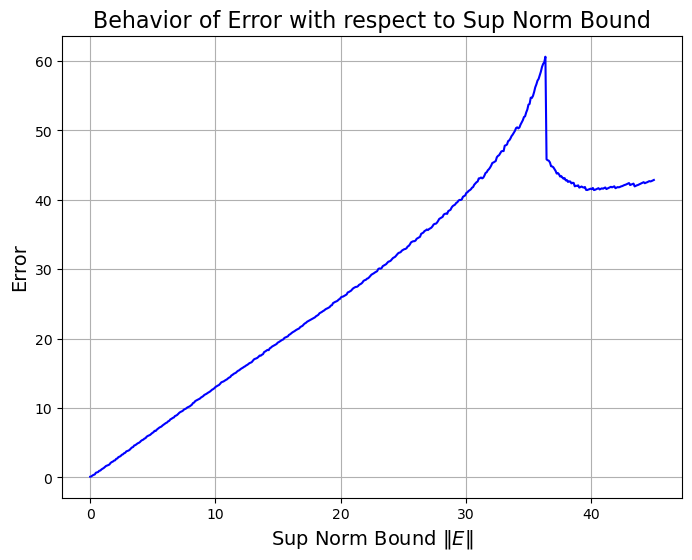

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(sup_norm_bounds, errors, label='Error vs. sup_norm_bound', color='b')
plt.xlabel(r'Sup Norm Bound $\|E\|$', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Behavior of Error with respect to Sup Norm Bound', fontsize=16)
plt.grid(True)
plt.savefig('error_vs_sup_norm_bound.png')
plt.show()

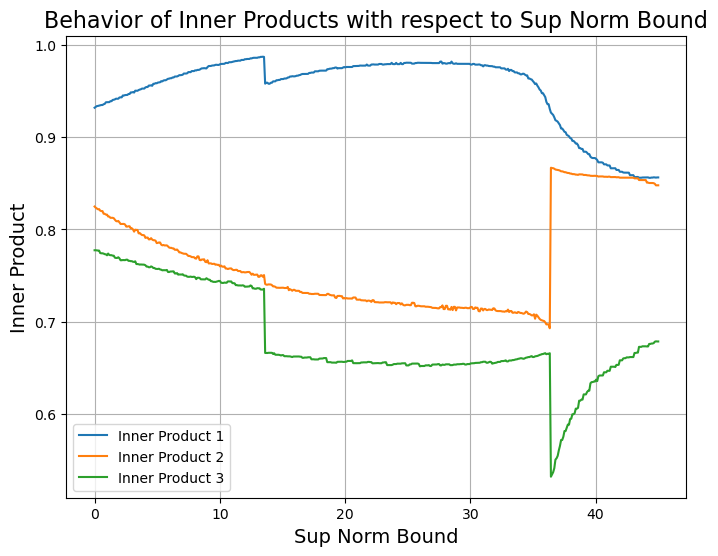

In [124]:
# Plot the inner products
plt.figure(figsize=(8, 6))
for i in range(sorted_inner_products.shape[1]):  # Loop through each eigenvector index
    plt.plot(sup_norm_bounds, sorted_inner_products[:, i], label=f'Inner Product {i+1}')
plt.xlabel('Sup Norm Bound', fontsize=14)
plt.ylabel('Inner Product', fontsize=14)
plt.title('Behavior of Inner Products with respect to Sup Norm Bound', fontsize=16)
plt.grid(True)
plt.legend()
plt.savefig('ipdt_vs_sup_norm_bound.png')
plt.show()

In [54]:
# Define the range of k values
k_values = range(3, 11)  # Example: Testing k from 3 to 20
sup_norm_bound = 0.5
# Compute errors
errors_vs_k = compute_errors_vs_k(k_values, sup_norm_bound, L, M)


Computing Errors for different k: 100%|██████████████████████| 8/8 [00:47<00:00,  5.89s/it]


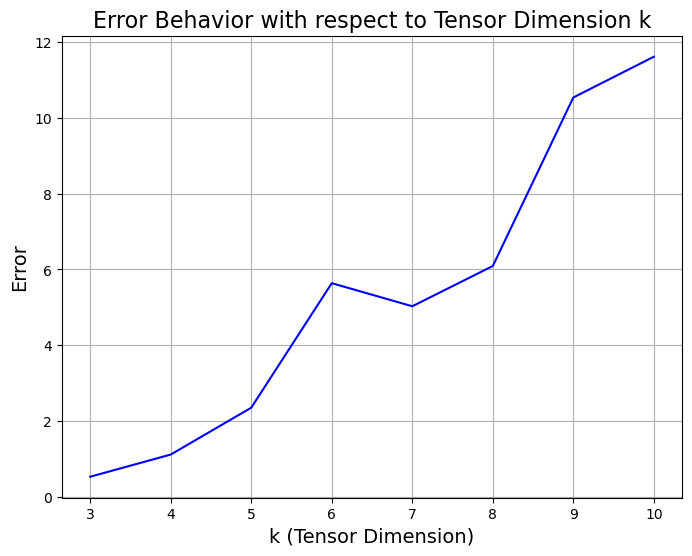

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, errors_vs_k, color='b')
plt.xlabel('k (Tensor Dimension)', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Error Behavior with respect to Tensor Dimension k', fontsize=16)
plt.grid(True)
plt.savefig('error_vs_k.png')
plt.show()

In [37]:
# Number of topics
d = 7  # Number of distinct words in the vocabulary
l = 4000  # Number of words in the document
N = 10000  # Number of documents to generate
k_values = range(3, 11)
bow_errors_vs_k, bow_emp_errors_vs_k = compute_bow_errors_vs_k(k_values, L, M)

Computing Errors for different k: 100%|██████████████████████| 8/8 [00:07<00:00,  1.07it/s]


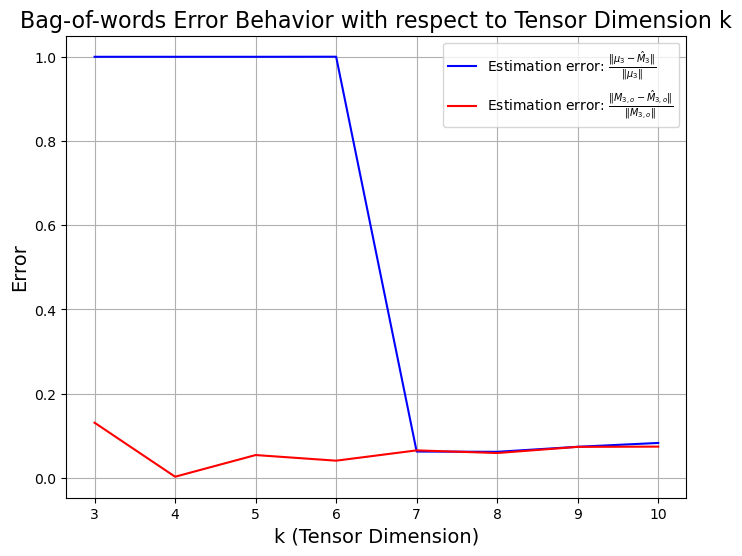

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, bow_errors_vs_k, color='b', label=r'Estimation error: $\frac{\|\mu_3 -\hat{M}_3\|}{\|\mu_3\|} $')
plt.plot(k_values, bow_emp_errors_vs_k, color='r', label=r'Estimation error: $\frac{\|M_{3,o} -\hat{M}_{3,o}\|}{\|M_{3,o}\|} $')
plt.xlabel('k (Tensor Dimension)', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Bag-of-words Error Behavior with respect to Tensor Dimension k', fontsize=16)
plt.grid(True)
plt.legend()
plt.savefig('bow_error_vs_k.png')
plt.show()